---
# Zillow Regression Project 
---

<img src="https://1000logos.net/wp-content/uploads/2017/12/Zillow_logo_PNG2.png" alt="Zillow" title="Zillow Logo" width="400" height="200" />

---
## Executive Summary
---

---
## Plan
---

- [x] Create README.md with data dictionary, project and business goals, come up with initial hypotheses.
- [x] Acquire data from the Codeup Database and create a function to automate this process. Save the function in an acquire.py file to import into the Final Report Notebook.
- [x] Clean and prepare data for the first iteration through the pipeline, MVP preparation. Create a function to automate the process, store the function in a prepare.py module, and prepare data in Final Report Notebook by importing and using the funtion.
- [x] Clearly define at least two hypotheses, set an alpha, run the statistical tests needed, reject or fail to reject the Null Hypothesis, and document findings and takeaways.
- [x] Establish a baseline accuracy and document well.
- [x] Train several different regression models.
- [x] Evaluate models on train and validate datasets.
- [x] Choose the model with that performs the best and evaluate that single model on the test dataset.
- [x] Document conclusions, takeaways, and next steps in the Final Report Notebook.

---
## Acquire
---

In [1]:
# standard imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# sklearn imports
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Custom module imports
import wrangle as w
import explore as e
import evaluate as ev 

In [2]:
# use function from wrangle module to acquire needed data, see wrangle.py for code
df = w.get_zillow_sfr_data()

In [3]:
df.shape

(28124, 8)

In [4]:
df.describe()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxamount,taxvaluedollarcnt,yearbuilt,fips
count,28124.000000,28124.000000,28077.000000,28123.000000,2.812300e+04,28053.000000,28124.000000
mean,3.309487,2.316509,1934.930014,6508.829263,5.350049e+05,1963.773179,6049.521121
std,0.943073,1.016983,995.684457,8221.720405,7.076811e+05,23.108952,21.302136
min,0.000000,0.000000,240.000000,51.260000,1.000000e+03,1878.000000,6037.000000
25%,3.000000,2.000000,1278.000000,2705.330000,1.986360e+05,1950.000000,6037.000000
50%,3.000000,2.000000,1675.000000,4735.280000,3.827980e+05,1961.000000,6037.000000
75%,4.000000,3.000000,2326.000000,7528.405000,6.327670e+05,1979.000000,6059.000000
max,12.000000,11.000000,17245.000000,276797.830000,2.385837e+07,2016.000000,6111.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28124 entries, 0 to 28123
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    28124 non-null  float64
 1   bathroomcnt                   28124 non-null  float64
 2   calculatedfinishedsquarefeet  28077 non-null  float64
 3   taxamount                     28123 non-null  float64
 4   taxvaluedollarcnt             28123 non-null  float64
 5   yearbuilt                     28053 non-null  float64
 6   fips                          28124 non-null  float64
 7   transactiondate               28124 non-null  object 
dtypes: float64(7), object(1)
memory usage: 1.9+ MB


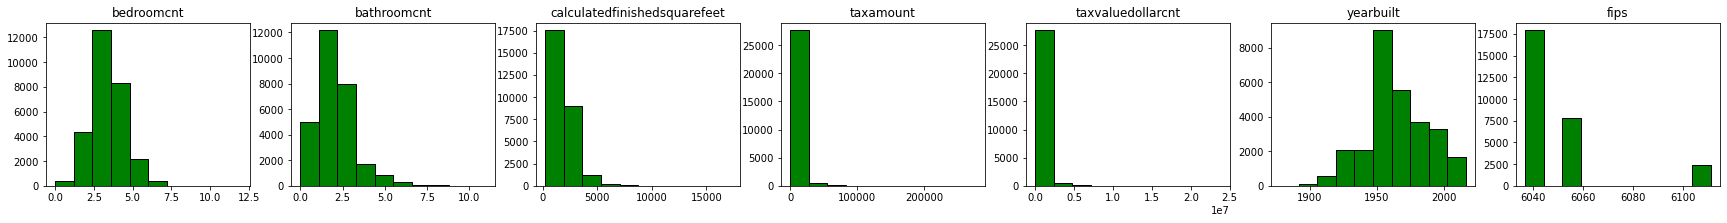

In [6]:
w.plot_distributions(df)

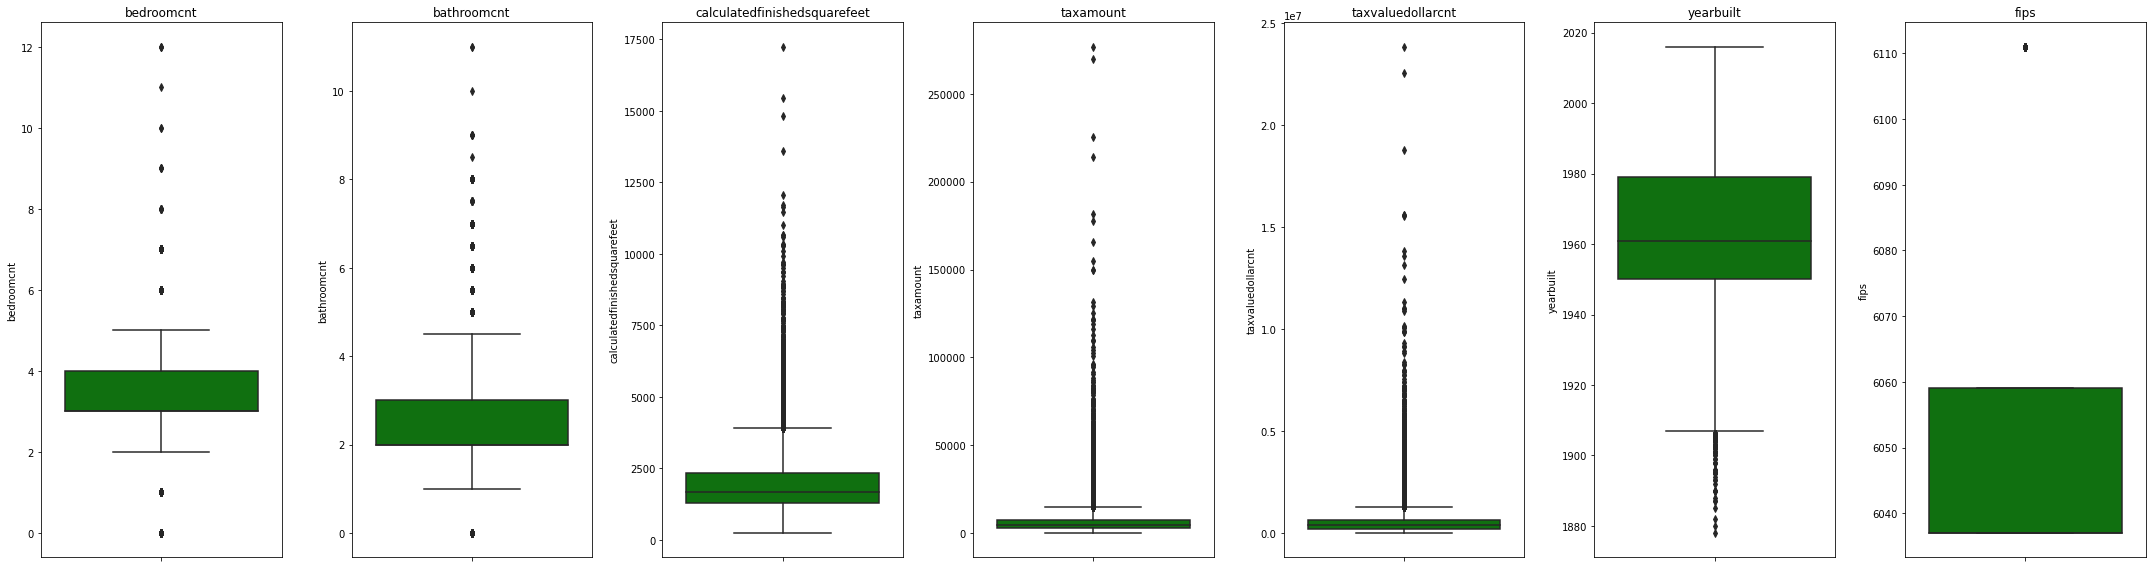

In [7]:
w.plot_boxplots(df)

### Takeaways:
- Have some outliers/erroneous data in all columns
- fips isn't actually numeric and should be changed to string

---
## Prepare
---

### Clean
- Dropped nulls
- Dropped duplicate rows
- Reformatted `fips` as string data type and preserved leading 0
- Adjusted data types of columns to more appropriately represent information
- Renamed columns for readability
- Added `tax_rate` column
- Eliminated outliers using `1.5*IQR Rule`

In [8]:
# use function to clean data, see wrangle.py for code
df = w.wrangle_zillow_no_split()
df.head()

,bedroom_cnt,bathroom_cnt,sqft,prop_tax,appraised_value,year_built,fips,transaction_date,tax_rate
0,3,2.0,1316,2627.48,205123.0,1923,06037,2017-07-21,0.012809
1,3,2.0,1458,2319.90,136104.0,1970,06037,2017-06-23,0.017045
2,2,1.0,1421,543.69,35606.0,1911,06037,2017-06-30,0.015270
3,4,3.0,2541,9819.72,880456.0,2003,06059,2017-06-01,0.011153
4,3,2.0,1491,1399.27,107110.0,1955,06037,2017-08-23,0.013064


In [9]:
df.head()

,bedroom_cnt,bathroom_cnt,sqft,prop_tax,appraised_value,year_built,fips,transaction_date,tax_rate
0,3,2.0,1316,2627.48,205123.0,1923,06037,2017-07-21,0.012809
1,3,2.0,1458,2319.90,136104.0,1970,06037,2017-06-23,0.017045
2,2,1.0,1421,543.69,35606.0,1911,06037,2017-06-30,0.015270
3,4,3.0,2541,9819.72,880456.0,2003,06059,2017-06-01,0.011153
4,3,2.0,1491,1399.27,107110.0,1955,06037,2017-08-23,0.013064


---
### Encode

In [10]:
# fips will need to be encoded since it is categorical
# I will drop columns derived from target since they will not be used in model
df_modeling = pd.get_dummies(data=df, columns=['fips'])
df_modeling = df_modeling.drop(columns=['prop_tax', 'tax_rate', 'transaction_date'])
df_modeling.head()

,bedroom_cnt,bathroom_cnt,sqft,appraised_value,year_built,fips_06037,fips_06059,fips_06111
0,3,2.0,1316,205123.0,1923,1,0,0
1,3,2.0,1458,136104.0,1970,1,0,0
2,2,1.0,1421,35606.0,1911,1,0,0
3,4,3.0,2541,880456.0,2003,0,1,0
4,3,2.0,1491,107110.0,1955,1,0,0


---
### Split

In [11]:
# split encoded df for scaling and modeling
train_encoded, validate_encoded, test_encoded = w.split_zillow(df_modeling)
print(train_encoded.shape, validate_encoded.shape, test_encoded.shape)
train_encoded.head()

(17309, 8) (2140, 8) (2162, 8)


,bedroom_cnt,bathroom_cnt,sqft,appraised_value,year_built,fips_06037,fips_06059,fips_06111
22113,3,2.0,1422,525223.0,1947,1,0,0
11771,4,3.0,1688,414349.0,1960,1,0,0
16027,4,2.5,2044,424126.0,1992,0,1,0
3443,3,2.0,1215,431814.0,1971,0,0,1
19279,3,3.0,2192,599606.0,1975,1,0,0


In [12]:
# split df for exploration
df_exploration = df.drop(columns=['prop_tax', 'tax_rate', 'transaction_date'])
train_explore, validate_explore, test_explore = w.split_zillow(df_exploration)
print(train_explore.shape, validate_explore.shape, test_explore.shape)
train_explore.head()

(17309, 6) (2140, 6) (2162, 6)


,bedroom_cnt,bathroom_cnt,sqft,appraised_value,year_built,fips
22113,3,2.0,1422,525223.0,1947,06037
11771,4,3.0,1688,414349.0,1960,06037
16027,4,2.5,2044,424126.0,1992,06059
3443,3,2.0,1215,431814.0,1971,06111
19279,3,3.0,2192,599606.0,1975,06037


---
### Scale

In [13]:
# scale dfs that will be used in modeling
cols = ['bedroom_cnt', 'bathroom_cnt', 'sqft', 'year_built']
train_scaled, validate_scaled, test_scaled = w.add_scaled_columns(train_encoded, validate_encoded, test_encoded, MinMaxScaler(), cols)
train_scaled.head()

,appraised_value,fips_06037,fips_06059,fips_06111,bedroom_cnt_scaled,bathroom_cnt_scaled,sqft_scaled,year_built_scaled
22113,525223.0,1,0,0,0.333333,0.333333,0.297665,0.352381
11771,414349.0,1,0,0,0.666667,0.666667,0.383917,0.476190
16027,424126.0,0,1,0,0.666667,0.500000,0.499351,0.780952
3443,431814.0,0,0,1,0.333333,0.333333,0.230545,0.580952
19279,599606.0,1,0,0,0.333333,0.666667,0.547341,0.619048


---
## Explore
---

### Tax Rate Distributions for each County

In [14]:
df.fips.value_counts()

06037    13287
06059     6258
06111     2066
Name: fips, dtype: Int64

**Fips Transation**
- 06037 = Los Angeles County, CA
- 06059 = Orange County, CA
- 06111 = Ventura County, CA

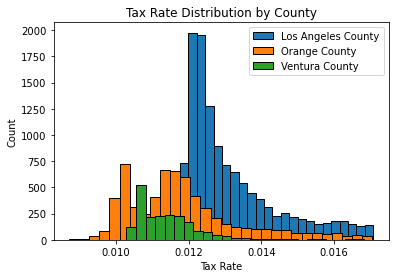

In [15]:
plt.title('Tax Rate Distribution by County')
df.tax_rate[df.fips == '06037'].hist(edgecolor='black', bins=30, label = 'Los Angeles County')
df.tax_rate[df.fips == '06059'].hist(edgecolor='black', bins=30, label = 'Orange County')
df.tax_rate[df.fips == '06111'].hist(edgecolor='black', bins=30, label = 'Ventura County')
plt.grid(False)
plt.xlabel('Tax Rate')
plt.ylabel('Count')
plt.legend();


### Univariate

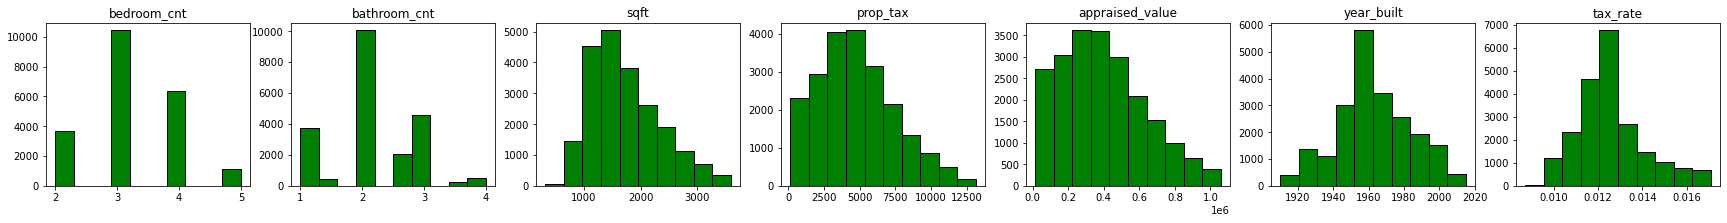

In [16]:
# check distributions after cleaning and removing outliers
w.plot_distributions(df)

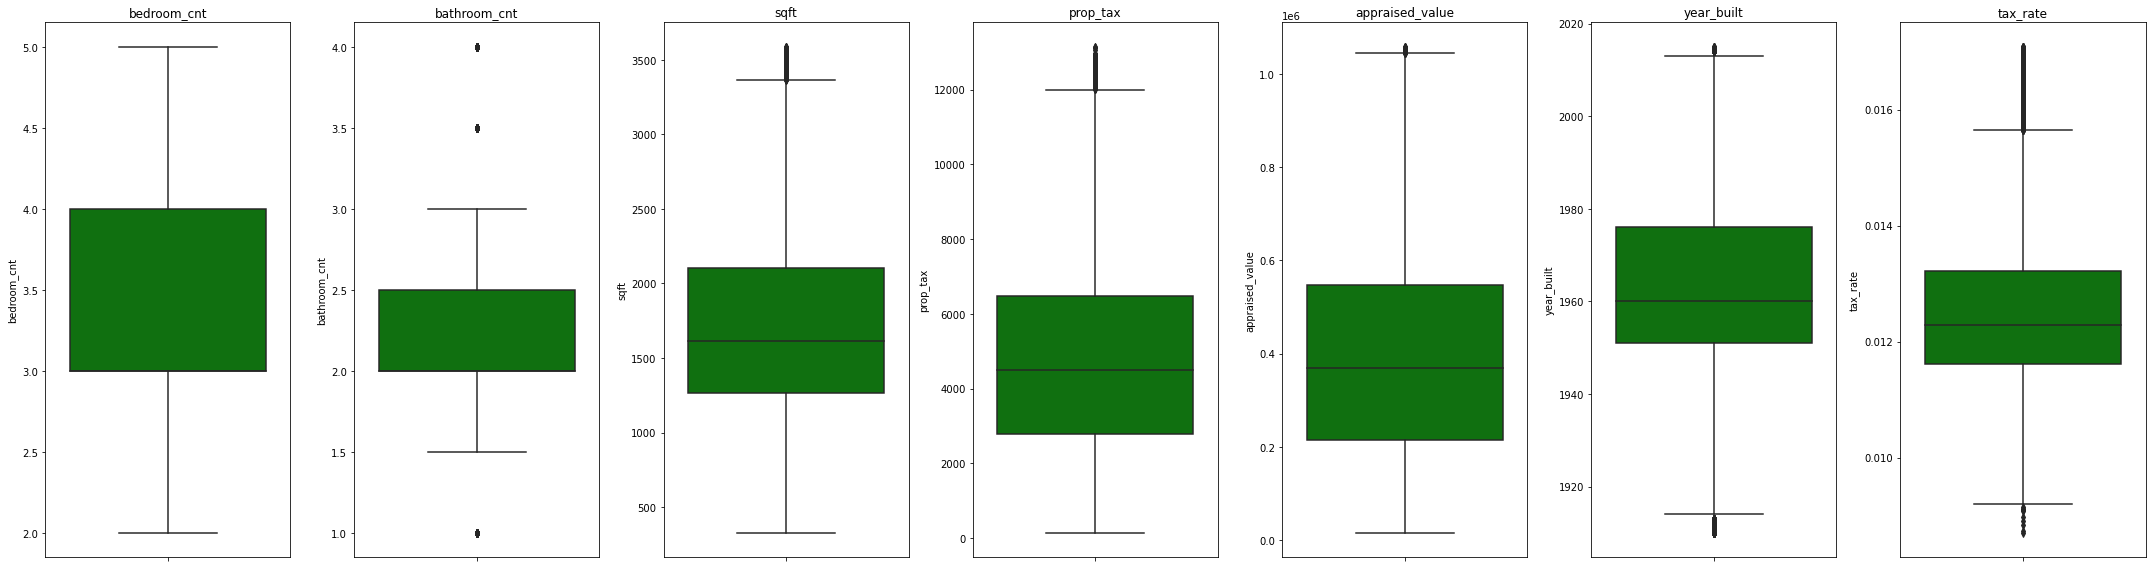

In [17]:
# check boxplots after cleaning and removing outliers
w.plot_boxplots(df)

---
### Bivariate


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fips
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

----------------------------------------------------------------------------------------------------------
bedroom_cnt
----------------------------------------------------------------------------------------------------------



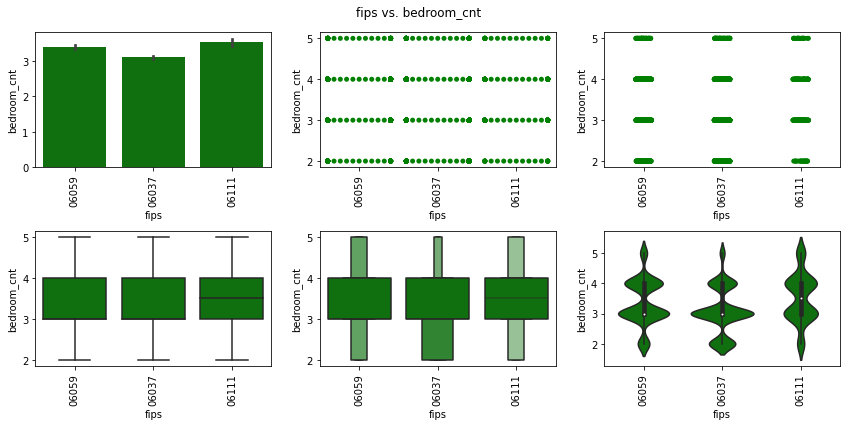


----------------------------------------------------------------------------------------------------------
bathroom_cnt
----------------------------------------------------------------------------------------------------------



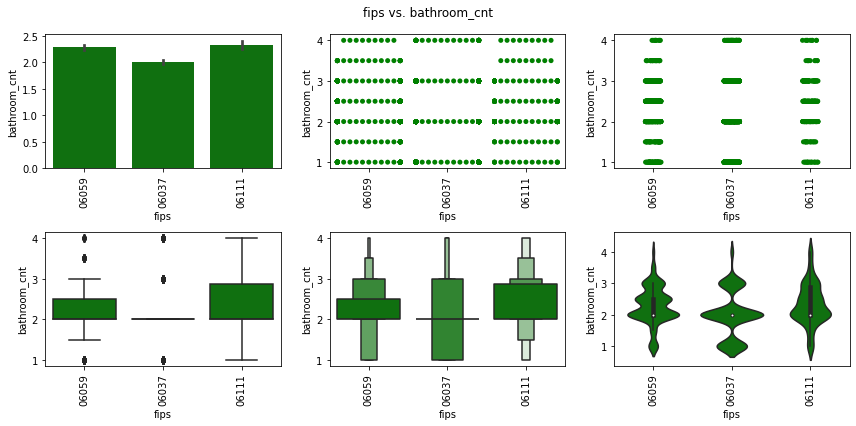


----------------------------------------------------------------------------------------------------------
sqft
----------------------------------------------------------------------------------------------------------



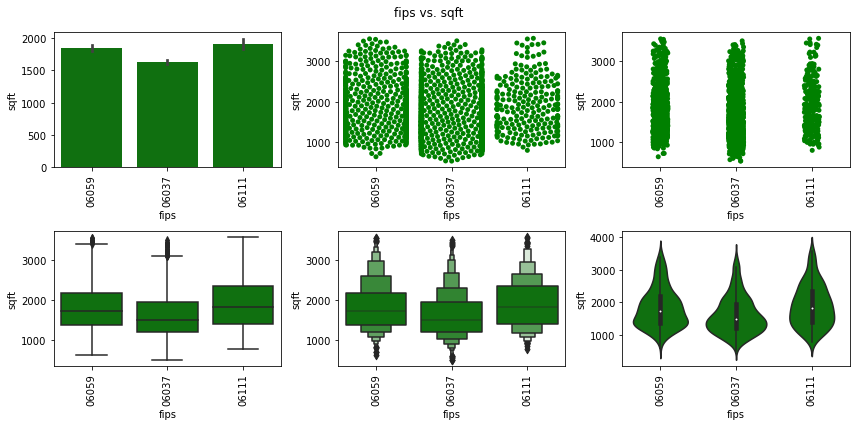


----------------------------------------------------------------------------------------------------------
appraised_value
----------------------------------------------------------------------------------------------------------



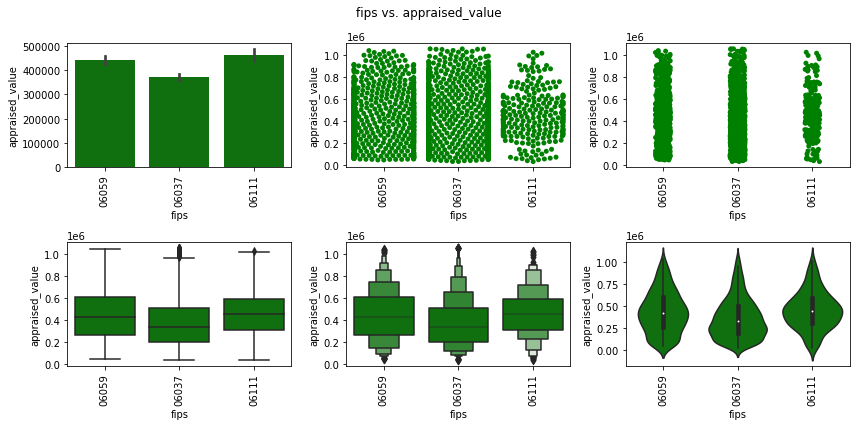


----------------------------------------------------------------------------------------------------------
year_built
----------------------------------------------------------------------------------------------------------



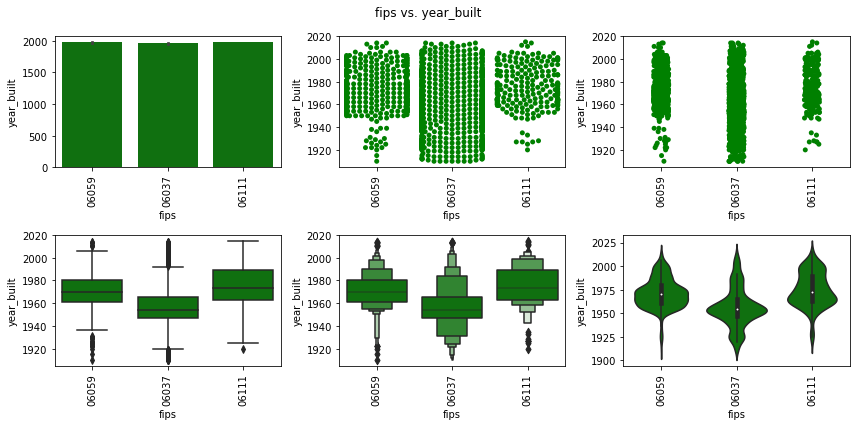

In [18]:
e.plot_categorical_and_continuous_vars(train_explore.sample(n=2500, random_state=527))

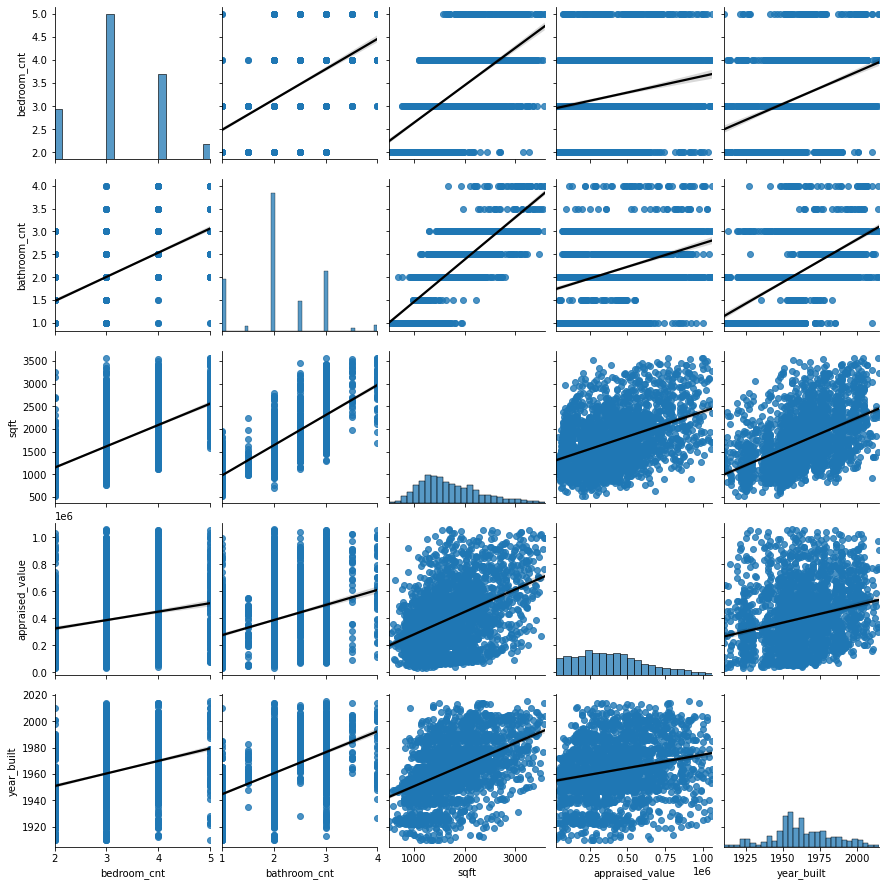

In [19]:
e.plot_variable_pairs(train_explore.sample(n=2500, random_state=527))

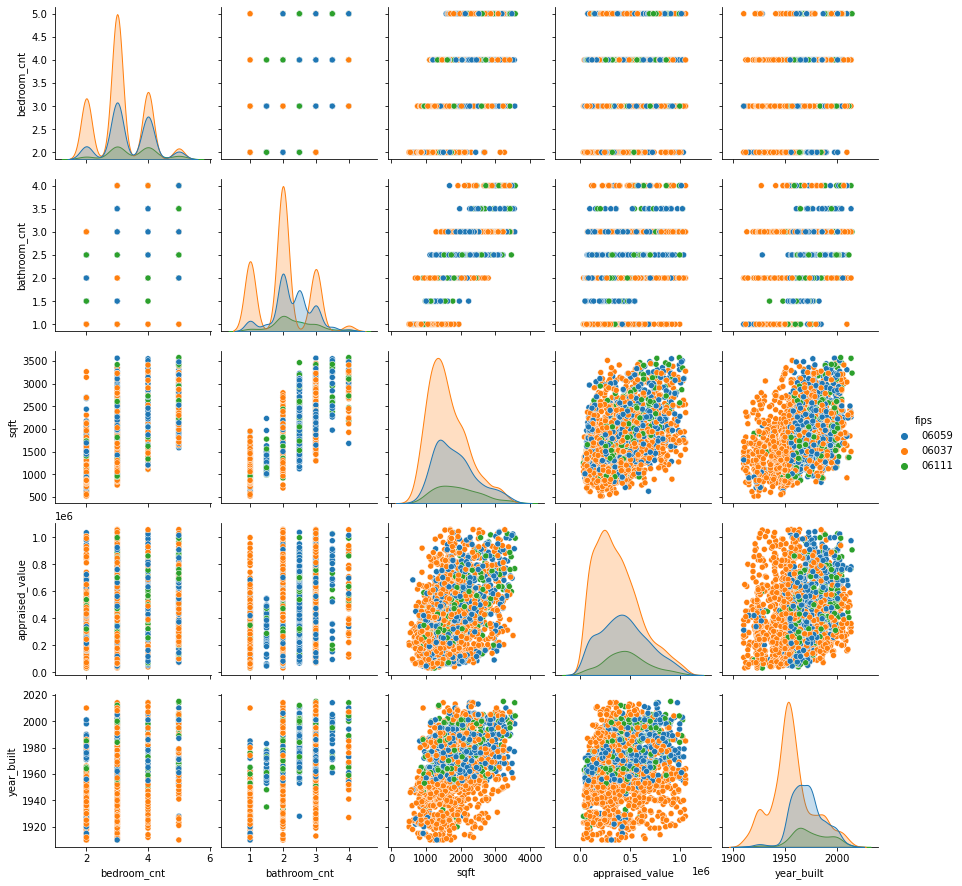

In [20]:
e.plot_variable_pairs_cat_hue(train_explore.sample(n=2500, random_state=527))

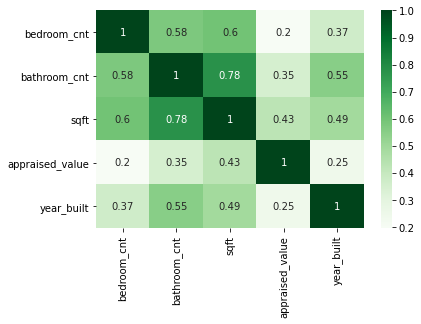

In [21]:
sns.heatmap(train_explore.corr(), annot=True, cmap='Greens');

**Above chart shows correlations between all variables (dependent and independent)**

---
### Statistical Tests

#### Correlation Tests

**Alpha value for all statistical testing is 0.05**

In [22]:
corr_cols = ['bedroom_cnt', 'bathroom_cnt', 'sqft', 'year_built']

**Null Hypotheses:**

In [23]:
for col in corr_cols:
    print(f'H_0: There is no linear relationship between appraised value and {col}')

H_0: There is no linear relationship between appraised value and bedroom_cnt
H_0: There is no linear relationship between appraised value and bathroom_cnt
H_0: There is no linear relationship between appraised value and sqft
H_0: There is no linear relationship between appraised value and year_built


**Alternative Hypotheses:**

In [24]:
for col in corr_cols:
    print(f'H_a: There is a linear relationship between appraised value and {col}')

H_a: There is a linear relationship between appraised value and bedroom_cnt
H_a: There is a linear relationship between appraised value and bathroom_cnt
H_a: There is a linear relationship between appraised value and sqft
H_a: There is a linear relationship between appraised value and year_built


**Pearson's Correlation Coefficient Test:**

In [25]:
for col in corr_cols:
    r, p = stats.pearsonr(train_explore.appraised_value, train_explore[col])
    print(f"Pearson's Correlation Coefficient Test results for appraised value vs {col}:\nr = {r:.2f}\np = {p:.3f}\n")

Pearson's Correlation Coefficient Test results for appraised value vs bedroom_cnt:
r = 0.20
p = 0.000

Pearson's Correlation Coefficient Test results for appraised value vs bathroom_cnt:
r = 0.35
p = 0.000

Pearson's Correlation Coefficient Test results for appraised value vs sqft:
r = 0.43
p = 0.000

Pearson's Correlation Coefficient Test results for appraised value vs year_built:
r = 0.25
p = 0.000



**Conclusions:**

In [26]:
for col in corr_cols:
    print(f'We reject the null hypothesis since there is a evidence of a linear relationship between appraised_value and {col} since p < alpha')

We reject the null hypothesis since there is a evidence of a linear relationship between appraised_value and bedroom_cnt since p < alpha
We reject the null hypothesis since there is a evidence of a linear relationship between appraised_value and bathroom_cnt since p < alpha
We reject the null hypothesis since there is a evidence of a linear relationship between appraised_value and sqft since p < alpha
We reject the null hypothesis since there is a evidence of a linear relationship between appraised_value and year_built since p < alpha


***Takeaway:***
- All of these features should be used in model

#### Mann-Whitney Test (non-parametric version of independent t-test)

**Null Hypotheses:**
- H_0: there is no difference in appraised_value for houses in LA County and Orange County
- H_0: there is no difference in appraised_value for houses in LA County and Ventura County
- H_0: there is no difference in appraised_value for houses in Orange County and Ventura County

**Alternate Hypotheses:**
- H_a: there is a difference in appraised_value for houses in LA County and Orange County
- H_a: there is a difference in appraised_value for houses in LA County and Ventura County
- H_a: there is a difference in appraised_value for houses in Orange County and Ventura County

In [27]:
# create subsets of appraised value for fips (only categorical variable)
LA_county = train_explore.appraised_value[train_explore.fips == '06037']
orange_county = train_explore.appraised_value[train_explore.fips == '06059']
ventura_county = train_explore.appraised_value[train_explore.fips == '06111']

In [28]:
print(f'Mean appraised value for Los Angeles County: ${LA_county.mean():.2f}')
print(f'Mean appraised value for Orange County: ${orange_county.mean():.2f}')
print(f'Mean appraised value for Ventura County: ${ventura_county.mean():.2f}')

Mean appraised value for Los Angeles County: $368003.23
Mean appraised value for Orange County: $452058.18
Mean appraised value for Ventura County: $429587.73


In [29]:
stat, p = stats.mannwhitneyu(LA_county, orange_county, alternative='two-sided')
print(f'Mann-Whitney Test Results for LA County vs Orange County:\nTest Statistic: {stat:.2f}\nP-Value: {p:.3f}')

Mann-Whitney Test Results for LA County vs Orange County:
Test Statistic: 21047533.00
P-Value: 0.000


In [30]:
stat, p = stats.mannwhitneyu(LA_county, ventura_county, alternative='two-sided')
print(f'Mann-Whitney Test Results for LA County vs Ventura County:\nTest Statistic: {stat:.2f}\nP-Value: {p:.3f}')

Mann-Whitney Test Results for LA County vs Ventura County:
Test Statistic: 7186212.00
P-Value: 0.000


In [31]:
stat, p = stats.mannwhitneyu(orange_county, ventura_county, alternative='two-sided')
print(f'Mann-Whitney Test Results for Orange County vs Ventura County:\nTest Statistic: {stat:.2f}\nP-Value: {p:.3f}')

Mann-Whitney Test Results for Orange County vs Ventura County:
Test Statistic: 4333355.50
P-Value: 0.002


**Conclusions:**
- We reject the null, there is evidence of a difference in appraised_value for houses in LA County and Orange County since p < 0.05
- We reject the null, there is evidence of a difference in appraised_value for houses in LA County and Orange County
- We reject the null, there is evidence of a difference in appraised_value for houses in LA County and Ventura County
- We reject the null, there is evidence of a difference in appraised_value for houses in Orange County and Ventura County

***Takeaway:***
- fips column should be used in model

### Additional Feature Analysis

#### SelectKBest

In [32]:
e.select_kbest(train_scaled.drop(columns=['appraised_value']), train_scaled.appraised_value, 5)

['fips_06037',
 'bedroom_cnt_scaled',
 'bathroom_cnt_scaled',
 'sqft_scaled',
 'year_built_scaled']

#### RFE

In [33]:
e.show_rfe_feature_ranking(train_scaled.drop(columns=['appraised_value']), train_scaled.appraised_value)

fips_06037             1
fips_06111             2
fips_06059             3
sqft_scaled            4
bedroom_cnt_scaled     5
bathroom_cnt_scaled    6
year_built_scaled      7
dtype: int64

---
## Model/Evaluate
---

### X and y

In [34]:
# split into X and y for all splits
X_train = train_scaled.drop(columns='appraised_value')
y_train = train_scaled.appraised_value
X_validate = validate_scaled.drop(columns='appraised_value')
y_validate = validate_scaled.appraised_value
X_test = test_scaled.drop(columns='appraised_value')
y_test = test_scaled.appraised_value

In [35]:
total = X_train.shape[0] + X_validate.shape[0] + X_test.shape[0]
print(f'Train Proportion: {(X_train.shape[0]/total):.2f}\nValidate Proportion: {(X_validate.shape[0]/total):.2f}\nTest Proportion: {(X_test.shape[0]/total):.2f}')

Train Proportion: 0.80
Validate Proportion: 0.10
Test Proportion: 0.10


### Target Distribution

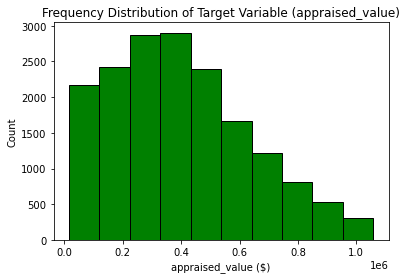

In [36]:
plt.hist(y_train, color='green', edgecolor='black')
plt.title('Frequency Distribution of Target Variable (appraised_value)')
plt.xlabel('appraised_value ($)')
plt.ylabel('Count');

***Doesn't look completely normal***

### Baseline

In [37]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# Predict baseline_mean
baseline_mean = y_train.appraised_value.mean()
y_train['baseline_mean'] = baseline_mean
y_validate['baseline_mean'] = baseline_mean

# Predict baseline_median
baseline_median = y_train.appraised_value.median()
y_train['baseline_median'] = baseline_median
y_validate['baseline_median'] = baseline_median

In [38]:
# create empty df to start appending to
metric_df = pd.DataFrame()

In [39]:
# get metrics for baseline mean model
metric_df = ev.make_metric_df(y_train.appraised_value, 
                           y_train.baseline_mean, 
                           y_validate.appraised_value, 
                           y_validate.baseline_mean, 
                           'baseline_mean', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,234166.35,235210.75,-1044.4,0.0,0.0,-0.0


In [40]:
# get metrics for baseline median model
metric_df = ev.make_metric_df(y_train.appraised_value, 
                           y_train.baseline_median, 
                           y_validate.appraised_value, 
                           y_validate.baseline_median, 
                           'baseline_median', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,234166.35,235210.75,-1044.40,0.0,0.0,-0.0
1,baseline_median,235844.69,237317.28,-1472.58,-0.0,0.0,-0.0


### LinearRegression (OLS)

In [41]:
# make model
ols = LinearRegression(normalize=True)

# fit model
ols.fit(X_train, y_train.appraised_value)

# Make prediction for train and validate
y_train['ols_y_pred'] = ols.predict(X_train)
y_validate['ols_y_pred'] = ols.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.appraised_value, 
                           y_train.ols_y_pred, 
                           y_validate.appraised_value, 
                           y_validate.ols_y_pred, 
                           'OLS', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,234166.35,235210.75,-1044.40,0.0,0.0,-0.0
1,baseline_median,235844.69,237317.28,-1472.58,-0.0,0.0,-0.0
2,OLS,209689.98,210815.95,-1125.96,0.2,0.2,0.0


### LassoLars

In [42]:
# create the model
lars = LassoLars(alpha=1)

# fit the model
lars.fit(X_train, y_train.appraised_value)

# predict train
y_train['lars_y_pred_alpha_1'] = lars.predict(X_train)

# predict validate
y_validate['lars_y_pred_alpha_1'] = lars.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.appraised_value, 
                           y_train.lars_y_pred_alpha_1, 
                           y_validate.appraised_value, 
                           y_validate.lars_y_pred_alpha_1, 
                           'lasso_alpha_1', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,234166.35,235210.75,-1044.40,0.0,0.0,-0.0
1,baseline_median,235844.69,237317.28,-1472.58,-0.0,0.0,-0.0
2,OLS,209689.98,210815.95,-1125.96,0.2,0.2,0.0
3,lasso_alpha_1,209688.84,210825.36,-1136.52,0.2,0.2,0.0


In [43]:
# create the model
lars = LassoLars(alpha=2)

# fit the model
lars.fit(X_train, y_train.appraised_value)

# predict train
y_train['lars_y_pred_alpha_2'] = lars.predict(X_train)

# predict validate
y_validate['lars_y_pred_alpha_2'] = lars.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.appraised_value, 
                           y_train.lars_y_pred_alpha_2, 
                           y_validate.appraised_value, 
                           y_validate.lars_y_pred_alpha_2, 
                           'lasso_alpha_2', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,234166.35,235210.75,-1044.40,0.0,0.0,-0.0
1,baseline_median,235844.69,237317.28,-1472.58,-0.0,0.0,-0.0
2,OLS,209689.98,210815.95,-1125.96,0.2,0.2,0.0
3,lasso_alpha_1,209688.84,210825.36,-1136.52,0.2,0.2,0.0
4,lasso_alpha_2,209689.67,210827.06,-1137.38,0.2,0.2,0.0


In [44]:
# create the model
lars = LassoLars(alpha=3)

# fit the model
lars.fit(X_train, y_train.appraised_value)

# predict train
y_train['lars_y_pred_alpha_3'] = lars.predict(X_train)

# predict validate
y_validate['lars_y_pred_alpha_3'] = lars.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.appraised_value, 
                           y_train.lars_y_pred_alpha_3, 
                           y_validate.appraised_value, 
                           y_validate.lars_y_pred_alpha_3, 
                           'lasso_alpha_3', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,234166.35,235210.75,-1044.40,0.0,0.0,-0.0
1,baseline_median,235844.69,237317.28,-1472.58,-0.0,0.0,-0.0
2,OLS,209689.98,210815.95,-1125.96,0.2,0.2,0.0
3,lasso_alpha_1,209688.84,210825.36,-1136.52,0.2,0.2,0.0
4,lasso_alpha_2,209689.67,210827.06,-1137.38,0.2,0.2,0.0
5,lasso_alpha_3,209691.06,210829.32,-1138.26,0.2,0.2,0.0


###  TweedieRegressor (GLM)

In [45]:
# create the model
glm = TweedieRegressor(power=0, alpha=0)

# fit the model
glm.fit(X_train, y_train.appraised_value)

# predict train
y_train['glm_y_pred_normal'] = glm.predict(X_train)

# predict validate
y_validate['glm_y_pred_normal'] = glm.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.appraised_value, 
                           y_train.glm_y_pred_normal, 
                           y_validate.appraised_value, 
                           y_validate.glm_y_pred_normal, 
                           'glm_normal', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,234166.35,235210.75,-1044.40,0.0,0.0,-0.0
1,baseline_median,235844.69,237317.28,-1472.58,-0.0,0.0,-0.0
2,OLS,209689.98,210815.95,-1125.96,0.2,0.2,0.0
3,lasso_alpha_1,209688.84,210825.36,-1136.52,0.2,0.2,0.0
4,lasso_alpha_2,209689.67,210827.06,-1137.38,0.2,0.2,0.0
5,lasso_alpha_3,209691.06,210829.32,-1138.26,0.2,0.2,0.0
6,glm_normal,209688.57,210824.24,-1135.67,0.2,0.2,0.0


In [46]:
# create the model
glm = TweedieRegressor(power=1, alpha=0)

# fit the model
glm.fit(X_train, y_train.appraised_value)

# predict train
y_train['glm_y_pred_poisson'] = glm.predict(X_train)

# predict validate
y_validate['glm_y_pred_poisson'] = glm.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.appraised_value, 
                           y_train.glm_y_pred_poisson, 
                           y_validate.appraised_value, 
                           y_validate.glm_y_pred_poisson, 
                           'glm_poisson', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,234166.35,235210.75,-1044.40,0.0,0.0,-0.00
1,baseline_median,235844.69,237317.28,-1472.58,-0.0,0.0,-0.00
2,OLS,209689.98,210815.95,-1125.96,0.2,0.2,0.00
3,lasso_alpha_1,209688.84,210825.36,-1136.52,0.2,0.2,0.00
4,lasso_alpha_2,209689.67,210827.06,-1137.38,0.2,0.2,0.00
5,lasso_alpha_3,209691.06,210829.32,-1138.26,0.2,0.2,0.00
6,glm_normal,209688.57,210824.24,-1135.67,0.2,0.2,0.00
7,glm_poisson,209236.42,210927.54,-1691.12,0.2,0.2,0.01


In [47]:
# create the model
glm = TweedieRegressor(power=1.5, alpha=0)

# fit the model
glm.fit(X_train, y_train.appraised_value)

# predict train
y_train['glm_y_pred_poisson_gamma'] = glm.predict(X_train)

# predict validate
y_validate['glm_y_pred_poisson_gamma'] = glm.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.appraised_value, 
                           y_train.glm_y_pred_poisson_gamma, 
                           y_validate.appraised_value, 
                           y_validate.glm_y_pred_poisson_gamma, 
                           'glm_poisson_gamma', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,234166.35,235210.75,-1044.40,0.0,0.00,-0.00
1,baseline_median,235844.69,237317.28,-1472.58,-0.0,0.00,-0.00
2,OLS,209689.98,210815.95,-1125.96,0.2,0.20,0.00
3,lasso_alpha_1,209688.84,210825.36,-1136.52,0.2,0.20,0.00
4,lasso_alpha_2,209689.67,210827.06,-1137.38,0.2,0.20,0.00
5,lasso_alpha_3,209691.06,210829.32,-1138.26,0.2,0.20,0.00
6,glm_normal,209688.57,210824.24,-1135.67,0.2,0.20,0.00
7,glm_poisson,209236.42,210927.54,-1691.12,0.2,0.20,0.01
8,glm_poisson_gamma,209321.37,211061.03,-1739.66,0.2,0.19,0.01


In [48]:
# create the model
glm = TweedieRegressor(power=2, alpha=0)

# fit the model
glm.fit(X_train, y_train.appraised_value)

# predict train
y_train['glm_y_pred_gamma'] = glm.predict(X_train)

# predict validate
y_validate['glm_y_pred_gamma'] = glm.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.appraised_value, 
                           y_train.glm_y_pred_gamma, 
                           y_validate.appraised_value, 
                           y_validate.glm_y_pred_gamma, 
                           'glm_gamma', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,234166.35,235210.75,-1044.40,0.0,0.00,-0.00
1,baseline_median,235844.69,237317.28,-1472.58,-0.0,0.00,-0.00
2,OLS,209689.98,210815.95,-1125.96,0.2,0.20,0.00
3,lasso_alpha_1,209688.84,210825.36,-1136.52,0.2,0.20,0.00
4,lasso_alpha_2,209689.67,210827.06,-1137.38,0.2,0.20,0.00
5,lasso_alpha_3,209691.06,210829.32,-1138.26,0.2,0.20,0.00
6,glm_normal,209688.57,210824.24,-1135.67,0.2,0.20,0.00
7,glm_poisson,209236.42,210927.54,-1691.12,0.2,0.20,0.01
8,glm_poisson_gamma,209321.37,211061.03,-1739.66,0.2,0.19,0.01
9,glm_gamma,209430.43,211214.59,-1784.15,0.2,0.19,0.01


In [49]:
# create the model
glm = TweedieRegressor(power=3, alpha=0)

# fit the model
glm.fit(X_train, y_train.appraised_value)

# predict train
y_train['glm_y_pred_i_gauss'] = glm.predict(X_train)

# predict validate
y_validate['glm_y_pred_i_gauss'] = glm.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.appraised_value, 
                           y_train.glm_y_pred_i_gauss, 
                           y_validate.appraised_value, 
                           y_validate.glm_y_pred_i_gauss, 
                           'glm_i_gauss', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,234166.35,235210.75,-1044.40,0.0,0.00,-0.00
1,baseline_median,235844.69,237317.28,-1472.58,-0.0,0.00,-0.00
2,OLS,209689.98,210815.95,-1125.96,0.2,0.20,0.00
3,lasso_alpha_1,209688.84,210825.36,-1136.52,0.2,0.20,0.00
4,lasso_alpha_2,209689.67,210827.06,-1137.38,0.2,0.20,0.00
5,lasso_alpha_3,209691.06,210829.32,-1138.26,0.2,0.20,0.00
6,glm_normal,209688.57,210824.24,-1135.67,0.2,0.20,0.00
7,glm_poisson,209236.42,210927.54,-1691.12,0.2,0.20,0.01
8,glm_poisson_gamma,209321.37,211061.03,-1739.66,0.2,0.19,0.01
9,glm_gamma,209430.43,211214.59,-1784.15,0.2,0.19,0.01


### Polynomial Regression

#### PolynomialFeatures

In [50]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate
X_validate_degree2 = pf.transform(X_validate)

In [51]:
# make the polynomial features to get a new set of features
pf3 = PolynomialFeatures(degree=3)

# fit and transform X_train
X_train_degree3 = pf3.fit_transform(X_train)

# transform X_validate
X_validate_degree3 = pf3.transform(X_validate)

#### LinearRegression

In [52]:
# create the model
lm2 = LinearRegression(normalize=True)

# fit the model
lm2.fit(X_train_degree2, y_train.appraised_value)

# predict train
y_train['lm2_y_pred'] = lm2.predict(X_train_degree2)

# predict validate
y_validate['lm2_y_pred'] = lm2.predict(X_validate_degree2)

# get metrics
metric_df = ev.make_metric_df(y_train.appraised_value, 
                           y_train.lm2_y_pred, 
                           y_validate.appraised_value, 
                           y_validate.lm2_y_pred, 
                           'lm2', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,234166.35,235210.75,-1044.40,0.00,0.00,-0.00
1,baseline_median,235844.69,237317.28,-1472.58,-0.00,0.00,-0.00
2,OLS,209689.98,210815.95,-1125.96,0.20,0.20,0.00
3,lasso_alpha_1,209688.84,210825.36,-1136.52,0.20,0.20,0.00
4,lasso_alpha_2,209689.67,210827.06,-1137.38,0.20,0.20,0.00
5,lasso_alpha_3,209691.06,210829.32,-1138.26,0.20,0.20,0.00
6,glm_normal,209688.57,210824.24,-1135.67,0.20,0.20,0.00
7,glm_poisson,209236.42,210927.54,-1691.12,0.20,0.20,0.01
8,glm_poisson_gamma,209321.37,211061.03,-1739.66,0.20,0.19,0.01
9,glm_gamma,209430.43,211214.59,-1784.15,0.20,0.19,0.01


In [53]:
# create the model
lm3 = LinearRegression(normalize=True)

# fit the model
lm3.fit(X_train_degree3, y_train.appraised_value)

# predict train
y_train['lm3_y_pred'] = lm3.predict(X_train_degree3)

# predict validate
y_validate['lm3_y_pred'] = lm3.predict(X_validate_degree3)

# get metrics
metric_df = ev.make_metric_df(y_train.appraised_value, 
                           y_train.lm3_y_pred, 
                           y_validate.appraised_value, 
                           y_validate.lm3_y_pred, 
                           'lm3', 
                           metric_df)
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,234166.35,235210.75,-1044.40,0.00,0.00,-0.00
1,baseline_median,235844.69,237317.28,-1472.58,-0.00,0.00,-0.00
2,OLS,209689.98,210815.95,-1125.96,0.20,0.20,0.00
3,lasso_alpha_1,209688.84,210825.36,-1136.52,0.20,0.20,0.00
4,lasso_alpha_2,209689.67,210827.06,-1137.38,0.20,0.20,0.00
5,lasso_alpha_3,209691.06,210829.32,-1138.26,0.20,0.20,0.00
6,glm_normal,209688.57,210824.24,-1135.67,0.20,0.20,0.00
7,glm_poisson,209236.42,210927.54,-1691.12,0.20,0.20,0.01
8,glm_poisson_gamma,209321.37,211061.03,-1739.66,0.20,0.19,0.01
9,glm_gamma,209430.43,211214.59,-1784.15,0.20,0.19,0.01


### Residual Plots

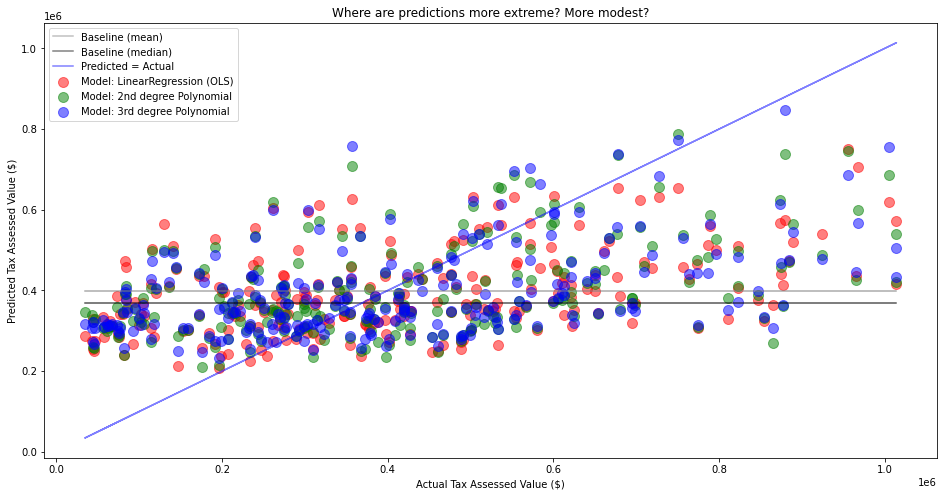

In [54]:
# create residual plots
# ols_y_pred, lm2_y_pred, lm3_y_pred
plt.figure(figsize=(16,8))
plt.plot(y_validate.appraised_value.sample(n=250, random_state=527), y_validate.baseline_mean.sample(n=250, random_state=527), alpha=.5, color="gray", label='Baseline (mean)')
plt.plot(y_validate.appraised_value.sample(n=250, random_state=527), y_validate.baseline_median.sample(n=250, random_state=527), alpha=.5, color="black", label='Baseline (median)')
plt.plot(y_validate.appraised_value.sample(n=250, random_state=527), y_validate.appraised_value.sample(n=250, random_state=527), alpha=.5, color="blue", label='Predicted = Actual')

plt.scatter(y_validate.appraised_value.sample(n=250, random_state=527), y_validate.ols_y_pred.sample(n=250, random_state=527), 
            alpha=.5, color="red", s=100, label="Model: LinearRegression (OLS)")
plt.scatter(y_validate.appraised_value.sample(n=250, random_state=527), y_validate.lm2_y_pred.sample(n=250, random_state=527), 
            alpha=.5, color="green", s=100, label="Model: 2nd degree Polynomial")
plt.scatter(y_validate.appraised_value.sample(n=250, random_state=527), y_validate.lm3_y_pred.sample(n=250, random_state=527), 
            alpha=.5, color="blue", s=100, label="Model: 3rd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Assessed Value ($)")
plt.ylabel("Predicted Tax Assessed Value ($)")
plt.title("Where are predictions more extreme? More modest?")
plt.show()

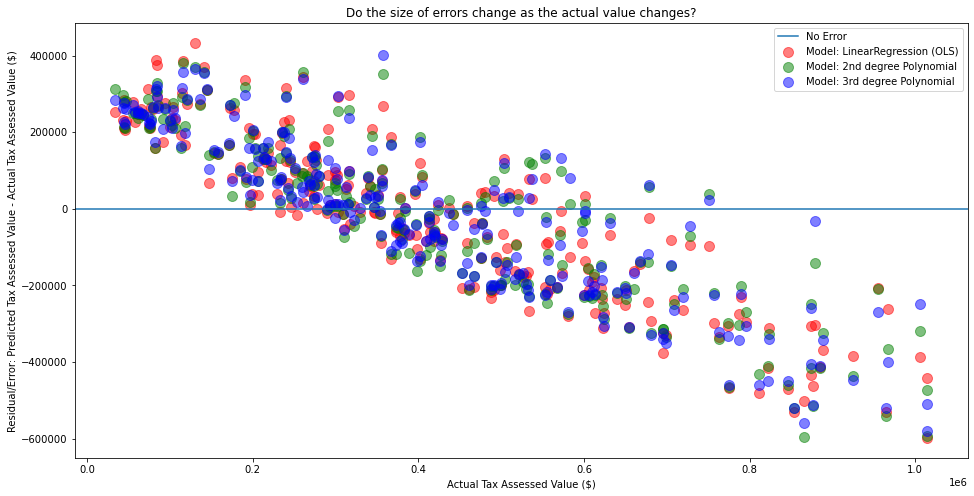

In [55]:
# ols_y_pred, lars_y_pred_alpha_1, lm2_y_pred, lm3_y_pred
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.appraised_value.sample(n=250, random_state=527), (y_validate.ols_y_pred - y_validate.appraised_value).sample(n=250, random_state=527), 
            alpha=.5, color="red", s=100, label="Model: LinearRegression (OLS)")
plt.scatter(y_validate.appraised_value.sample(n=250, random_state=527), (y_validate.lm2_y_pred - y_validate.appraised_value).sample(n=250, random_state=527), 
            alpha=.5, color="green", s=100, label="Model: 2nd degree Polynomial")
plt.scatter(y_validate.appraised_value.sample(n=250, random_state=527), (y_validate.lm3_y_pred - y_validate.appraised_value).sample(n=250, random_state=527), 
            alpha=.5, color="blue", s=100, label="Model: 3rd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Assessed Value ($)")
plt.ylabel("Residual/Error: Predicted Tax Assessed Value - Actual Tax Assessed Value ($)")
plt.title("Do the size of errors change as the actual value changes?")
plt.show()

### Actual vs. Predicted Distributions

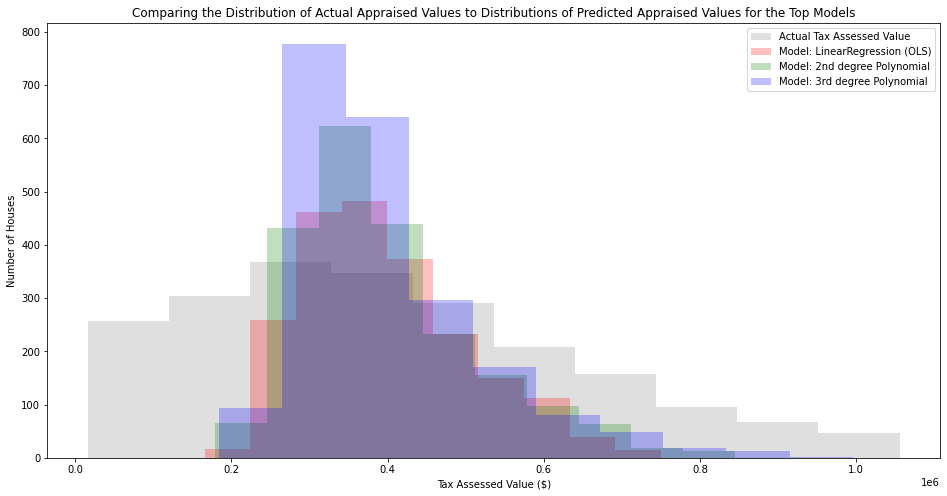

In [56]:
# plot to visualize actual vs predicted. 
# ols_y_pred, lars_y_pred_alpha_1, lm2_y_pred, lm3_y_pred
plt.figure(figsize=(16,8))
plt.hist(y_validate.appraised_value, color='gray', alpha=.25, label="Actual Tax Assessed Value")
plt.hist(y_validate.ols_y_pred, color='red', alpha=.25, label="Model: LinearRegression (OLS)")
plt.hist(y_validate.lm2_y_pred, color='green', alpha=.25, label="Model: 2nd degree Polynomial")
plt.hist(y_validate.lm3_y_pred, color='blue', alpha=.25, label="Model: 3rd degree Polynomial")
plt.xlabel("Tax Assessed Value ($)")
plt.ylabel("Number of Houses")
plt.title("Comparing the Distribution of Actual Appraised Values to Distributions of Predicted Appraised Values for the Top Models")
plt.legend()
plt.show()

### Evaluate Best-Performing Model on Test

In [57]:
y_test = pd.DataFrame(y_test)

# transform X_test
X_test_degree3 = pf3.transform(X_test)

# predict on test
y_test['lm3_y_pred'] = lm3.predict(X_test_degree3)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.appraised_value, y_test.lm3_y_pred, squared=False)
r2_test = explained_variance_score(y_test.appraised_value, y_test.lm3_y_pred)

print(f'RMSE for 3rd Degree Polynomial Regression\nOut-of-Sample Performance: {rmse_test:.2f}\nR^2: {r2_test:.2f}')

RMSE for 3rd Degree Polynomial Regression
Out-of-Sample Performance: 204074.85
R^2: 0.20


**Compare to Baseline:**

In [58]:
print(f'Model outperformed best baseline on validate:\nRMSE difference: ${(235210.75 - rmse_test):.2f}\nR^2 difference: {r2_test:.2f}')

Model outperformed best baseline on validate:
RMSE difference: $31135.90
R^2 difference: 0.20


## Conclusions and Next Steps

- County, sqft, number of bathrooms, number of bedrooms were best predictors
- Mode outperformed baseline and improved R^2 value by 20%